In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
data_sub = pd.read_excel('/content/drive/MyDrive/Data/data_Sub.xlsx')
data_instructor_timeslot = pd.read_excel('/content/drive/MyDrive/Data/data_FSlot_T.xlsx')
data_instructor_timeslot = data_instructor_timeslot.drop(data_instructor_timeslot.columns[0], axis = 1)
data_instructor_subject = pd.read_excel('/content/drive/MyDrive/Data/data_FSlot_S.xlsx')
data_instructor_subject = data_instructor_subject.drop(data_instructor_subject.columns[0], axis = 1)
data_rating = pd.read_excel('/content/drive/MyDrive/Data/data_Rating.xlsx')
data_rating = data_rating.drop(data_rating.columns[0], axis = 1)
data_ideal_course = pd.read_excel('/content/drive/MyDrive/Data/data_T.xlsx')
data_course_information = pd.read_excel('/content/drive/MyDrive/Data/sp22_to_import.xlsx')

In [4]:
subjects = data_sub.values
instructor_timeslot = data_instructor_timeslot.values
instructor_subject = data_instructor_subject.values
instructor_rating = data_rating.values
instructor_min_course = data_ideal_course['Min_course'].values
instructor_max_course = data_ideal_course['Max_course'].values
instructor_ideal_course = data_ideal_course['Ideal_course'].values
course_information = data_course_information[['CourseId', 'SubjectId', 'SlotId']].values

num_timeslots = instructor_timeslot.shape[1]
num_instructors = instructor_timeslot.shape[0]
num_subjects = subjects.shape[0]
num_courses = course_information.shape[0]

# Matrix F = B * S^-1 (F: quality_class)
course_subject = np.zeros((num_courses, num_subjects))
for i in range(num_courses):
    course_subject[course_information[i,0], course_information[i,1]] = 1
print(instructor_rating.shape, course_subject.shape)
quality_class = instructor_rating @ course_subject.transpose()

# Matrix E = A * S^-1
subject_preference_class = instructor_subject @ course_subject.transpose()

# Matrix H = C * T^-1 (H: timeslot_preference_class)
course_timeslot = np.zeros((num_courses, num_timeslots))
for i in range(num_courses):
    course_timeslot[course_information[i,0], course_information[i,2]] = 1
timeslot_preference_class = instructor_timeslot @ course_timeslot.transpose()

print("Num courses:", num_courses)
print("Num subjects:", num_subjects)
print("Num timeslots:", num_timeslots)
print("Num instructors:", num_instructors)
print(subject_preference_class)
print(subject_preference_class.shape)

(25, 13) (153, 13)
Num courses: 153
Num subjects: 13
Num timeslots: 10
Num instructors: 25
[[ 1.  1.  1. ...  1.  5.  0.]
 [10. 10. 10. ... 10.  3.  9.]
 [ 4.  4.  4. ...  4.  8.  8.]
 ...
 [ 6.  6.  6. ...  6.  6.  1.]
 [ 9.  9.  9. ...  9.  7.  8.]
 [ 2.  2.  2. ...  2.  4.  4.]]
(25, 153)


In [5]:
num_states = num_courses
num_actions = num_instructors

# Initialize the Q-table with zeros
Q = np.zeros((num_courses, 3000000, num_instructors))

D = np.zeros(num_courses)
courses = np.zeros((num_instructors))
courses_dict = {}
new_instructor_timeslot = np.zeros((num_instructors, num_timeslots))
id = 0
fitness_value = np.zeros(21000)
fitness_value_id = 0
# Set hyperparameters
alpha = 0.7  # Learning rate
gamma = 1  # Discount factor
epsilon = 1.0  # Exploration rate
max_epsilon = 1.0
min_epsilon = 0.001
decay_rate = 0.0003

w4 = w5 = 0.5
w1 = w2 = w3 = 1/3


In [6]:
max_D = np.zeros(num_courses)
max_courses = np.zeros((num_instructors))
final_courses = max_courses
max_fitness_value = 0
max_new_instructor_timeslot = np.zeros((num_instructors, num_timeslots))

In [7]:
def reduce_epsilon(epsilon, episode):
    return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)

In [8]:
def check(course, instructor_assignment):

    if(quality_class[instructor_assignment,course] == 0):
        return False

    if(subject_preference_class[instructor_assignment,course] == 0):
        return False

    if(timeslot_preference_class[instructor_assignment,course] == 0):
        return False

    if(courses[instructor_assignment] >= instructor_max_course[instructor_assignment]):
        return False

    timeslot_id = course_information[course,2]
    if(new_instructor_timeslot[instructor_assignment, timeslot_id]) >= 1:
        return False

    course_need = 0
    courses[instructor_assignment] += 1
    for i in range(num_instructors):
       course_need += max(0, instructor_min_course[i] - courses[i].astype(int))
    real_course = np.sum(courses.astype(int))
    courses[instructor_assignment] -= 1
    if(course_need > num_courses - real_course ):
        return False

    return True

In [9]:
# Define the reward function
def get_reward(course, instructor_assignment):
    global id
    D[course] = instructor_assignment
    courses[instructor_assignment] += 1

    courses_string = " ".join(str(v) for v in D.astype(int))
    if(courses_string not in courses_dict):
      courses_dict[courses_string] = id
      id += 1

    reward = 0
    if(course>81):
        for i in range(81,course+1):
            reward += w4 * quality_class[D[i].astype(int),i] + w5 * (w1 * subject_preference_class[D[i].astype(int),i] + w2 * timeslot_preference_class[D[i].astype(int),i])
    if(course < 81):
        for i in range(course, num_courses):
            reward += w4 * quality_class[D[i].astype(int),i] + w5 * (w1 * subject_preference_class[D[i].astype(int),i] + w2 * timeslot_preference_class[D[i].astype(int),i])
        for i in range(course+1):
            reward += w4 * quality_class[D[i].astype(int),i] + w5 * (w1 * subject_preference_class[D[i].astype(int),i] + w2 * timeslot_preference_class[D[i].astype(int),i])
    for i in range(num_instructors):
        reward += w5 * (w3 * (10-abs(instructor_ideal_course[i] - courses[i])))

    return reward
    # Return a reward based on the assignment quality

In [10]:
def getSatisfaction(teacher_id, course):
     return subject_preference_class[teacher_id,course] + timeslot_preference_class[teacher_id,course]+(10-abs(instructor_ideal_course[teacher_id] - courses[teacher_id]))

In [11]:
def getScore(teacher_id):
    score = 0
    for i in range(num_courses):
        if(D[i] == teacher_id):
            score += getSatisfaction(teacher_id, i) / 30
    return score

In [12]:
print(quality_class.shape)

(25, 153)


In [13]:
def getFitness():
    fitness = 0
    for i in range(num_courses):
        fitness += quality_class[D[i].astype(int),i]
        fitness += getSatisfaction(D[i].astype(int), i)/3
    return fitness/2

In [14]:
# Q-learning algorithm
def q_learning(num_episodes):
    global id, epsilon, fitness_value_id, max_fitness_value, max_D, max_new_instructor_timeslot, D, Q, max_courses, final_courses
    for episode in range(num_episodes):
        checkCondition = True
        new_instructor_timeslot.fill(0)
        courses[:] = 0
        D[:] = 0
        state = 81  # Initial state (course)
        fitness = 0
        done = False

        while not done and checkCondition == True:

            courses_string = " ".join(str(v) for v in D.astype(int))
            if(courses_string not in courses_dict):
              courses_dict[courses_string] = id
              id += 1

            count = 26
            # Epsilon-greedy exploration-exploitation
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(num_actions)  # Explore
                while (check(state, action) == False):
                    count -= 1
                    Q[state,courses_dict[courses_string], action] -= 3
                    action = np.random.randint(num_actions)
                    if (count == 0):
                        count = 26
                        action = np.argmax(Q[state,courses_dict[courses_string]])  # Exploit
                        while (check(state, action) == False or check(state, action)==0):
                            count -= 1
                            Q[state,courses_dict[courses_string], action] -= 3
                            action = np.argmax(Q[state,courses_dict[courses_string]])
                            if (count ==0):
                                if(check(state, action)==False):
                                    checkCondition = False
                                break
                        break

            else:
                action = np.argmax(Q[state,courses_dict[courses_string]])  # Exploit
                while (check(state, action) == False):
                    count -= 1
                    Q[state,courses_dict[courses_string], action] -= 3
                    action = np.argmax(Q[state,courses_dict[courses_string]])
                    if (count ==0):
                        if(check(state, action)==False):
                            checkCondition = False
                        break

            timeslot_id = course_information[state,2]
            new_instructor_timeslot[action, timeslot_id] += 1
            #print("action",action,new_instructor_timeslot[action])
            # Perform the action (course-instructor assignment)
            next_state = (state + 1) % num_states  # Move to the next course
            reward = get_reward(state, action)

            # Update Q-table
            next_courses_string = " ".join(str(v) for v in D.astype(int))
            if(next_courses_string not in courses_dict):
                courses_dict[next_courses_string] = id
                id += 1
            if(state != 80 and Q[state,courses_dict[courses_string], action]==0):
                Q[state,courses_dict[courses_string], action] += 0.01* reward
            elif(state != 80):
                #if(np.max(Q[next_state,courses_dict[next_courses_string]]) != 0):
                    Q[state,courses_dict[courses_string], action] += 0.01 * alpha * ( gamma * np.max(Q[next_state,courses_dict[next_courses_string]]) - Q[state,courses_dict[courses_string], action])
            elif(state == 80):
                Q[state,courses_dict[courses_string], action] = 0.01 * reward
            #print("action",action,D)
            state = next_state

            # Check if the episode is complete
            if state == 81:
                if(checkCondition==True):
                    fitness = reward
                    fitness_value[fitness_value_id]= fitness
                    fitness_value_id += 1
                    print("fitness",episode, fitness)
                    if(fitness > max_fitness_value):
                        max_fitness_value = fitness
                        max_D = np.copy(D)
                        max_courses = np.copy(courses)
                        max_new_instructor_timeslot = np.copy(new_instructor_timeslot)
                done = True
        print("episode",episode)
        epsilon = reduce_epsilon(epsilon, episode)
        print("epsilon", epsilon)
        print("max fitness",max_fitness_value)
    return Q

In [15]:
# Run the Q-learning algorithm
courses_dict = {}
num_episodes = 21000
epsilon = 1.0
training_Q = q_learning(num_episodes)

# # Assign courses based on the learned Q-values
max_epsilon = 0
min_epsilon = 0
final_Q = q_learning(1)
course_assignments = D.astype(int)

# Print the final Q-table and class assignments
print("Final Q-table:")
#print(final_Q)
print("Course Assignments:")
#print(course_assignments)
#print(course_assignments.shape)
print(max_D.astype(int))
print(max_courses.astype(int))
print(courses.astype(int))
print(instructor_min_course)
print(instructor_max_course)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
episode 19707
epsilon 0.0037037907738400443
max fitness 862.8333333333329
fitness 19708 818.5000000000002
episode 19708
epsilon 0.0037029797582663108
max fitness 862.8333333333329
fitness 19709 852.1666666666664
episode 19709
epsilon 0.0037021689859607593
max fitness 862.8333333333329
fitness 19710 855.333333333333
episode 19710
epsilon 0.003701358456850416
max fitness 862.8333333333329
fitness 19711 851.1666666666663
episode 19711
epsilon 0.0037005481708623357
max fitness 862.8333333333329
fitness 19712 855.333333333333
episode 19712
epsilon 0.003699738127923593
max fitness 862.8333333333329
fitness 19713 775.8333333333336
episode 19713
epsilon 0.0036989283279612855
max fitness 862.8333333333329
fitness 19714 778.5
episode 19714
epsilon 0.003698118770902527
max fitness 862.8333333333329
fitness 19715 810.3333333333336
episode 19715
epsilon 0.0036973094566744597
max fitness 862.8333333333329
fitness 19716 855.333333333333
episode

In [16]:
print(epsilon)
print(np.sum(courses.astype(int)))
print(id)
print(np.sum(instructor_min_course))
print(new_instructor_timeslot)
print(D.astype(int))
print(courses.astype(int))
print(instructor_min_course)
print(instructor_max_course)

0.0
153
1900056
60
[[1. 0. 1. 1. 0. 0. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 0. 0. 1. 1. 1.]
 [0. 1. 0. 0. 1. 0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 0. 1. 1. 0. 1. 1.]
 [1. 1. 0. 1. 0. 0. 1. 1. 0. 1.]
 [1. 0. 1. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 0. 0.]
 [1. 0. 1. 0. 1. 1. 1. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 1. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 1. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0. 1. 0.]]
[ 8  4 10  3  6  8  3  3  6 18 14 14 14 10  7  6 15 10 10  5  5  6  8  7
 11 21 23 16  7 23  6  6  8 19 23 12  6  7 12  5  5 14  7 16  9 15 12  9
 16 12 12

In [17]:
print(max_fitness_value)
print(max_D)
print(max_courses)
print(max_new_instructor_timeslot)
D = max_D
course_assignments = max_D.astype(int)
courses = max_courses
new_instructor_timeslot = max_new_instructor_timeslot

866.3333333333331
[ 8.  4. 10.  3.  6.  8.  3.  3.  6. 18. 14. 14. 14. 10.  7.  6. 15. 10.
 10.  5.  5.  6.  8.  7. 11. 21. 23. 16.  7. 23.  6.  6.  8. 19. 23. 12.
  6.  7. 12.  5.  5. 14.  7. 12.  9. 15. 10.  9. 16. 12. 12. 12. 13.  7.
 13. 21. 12.  7. 13. 19. 16. 23. 16. 13. 13. 14. 14. 19. 15. 23. 24. 20.
 15. 16. 17. 17. 14. 16. 24. 24. 24. 11. 11.  4. 19. 17. 19. 20.  5. 21.
  4. 20.  0. 17.  4. 20.  5.  1. 10. 20.  0. 17.  0.  1.  0.  1. 18.  0.
  0. 18.  1.  1.  2. 21. 20.  3. 12.  2. 13.  9. 11.  8. 11.  8. 22.  1.
  3.  3.  9.  4.  6. 11.  4. 22.  9.  5.  2.  4. 22.  9. 21.  2.  3. 23.
 23. 16. 10. 19. 13.  7.  2.  5.  8.]
[6. 6. 5. 7. 7. 8. 8. 8. 7. 6. 7. 6. 8. 7. 7. 4. 7. 5. 3. 6. 6. 5. 3. 7.
 4.]
[[1. 0. 1. 1. 0. 0. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 0. 0. 1. 1. 1.]
 [0. 1. 0. 0. 1. 0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 1. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 0

[[8. 8. 8. ... 8. 5. 2.]
 [6. 6. 6. ... 6. 1. 3.]
 [3. 3. 3. ... 3. 9. 0.]
 ...
 [4. 4. 4. ... 4. 5. 2.]
 [4. 4. 4. ... 4. 3. 9.]
 [5. 5. 5. ... 5. 4. 3.]]


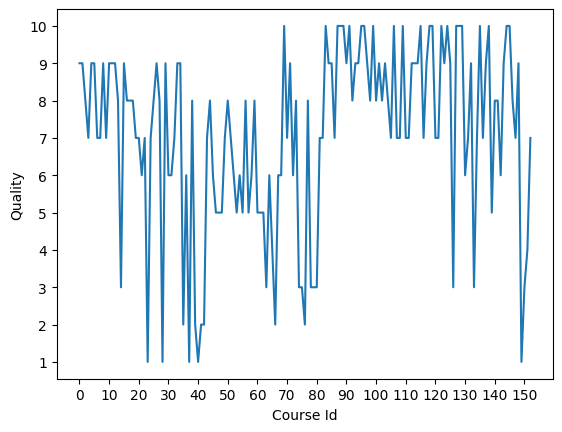

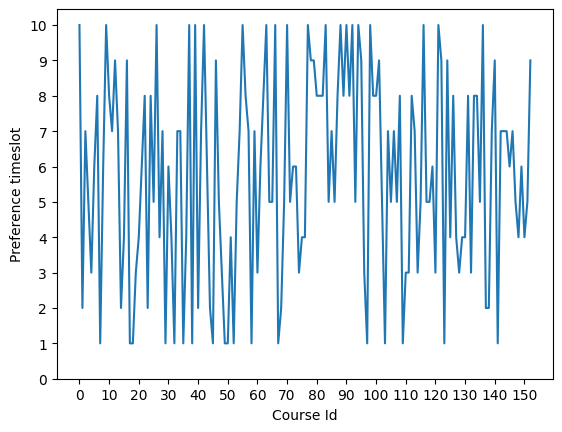

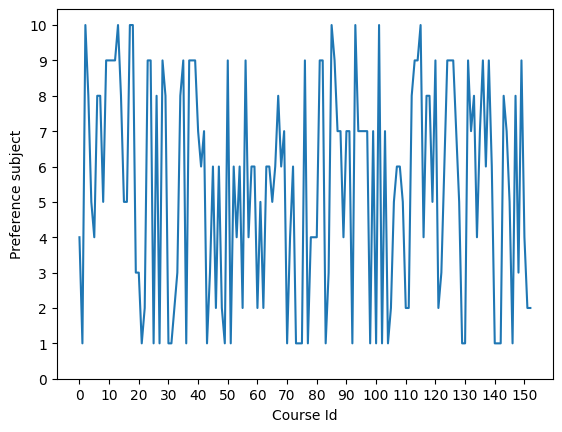

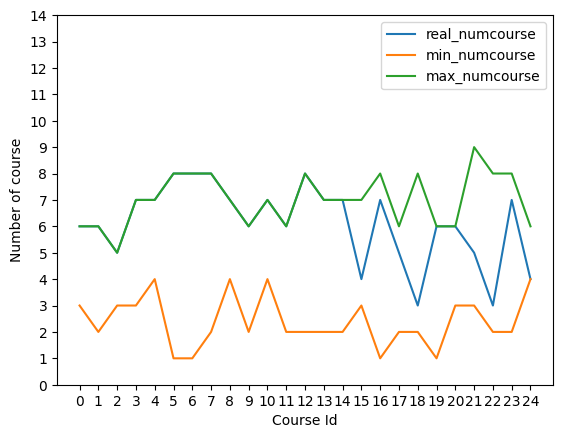

In [18]:
course_id = np.arange(0 ,153)
quality = np.zeros(153)
print(quality_class)
plt.yticks(range(0,11,1))
plt.xticks(range(0,153,10))
for i in range(153):
  quality[i] = quality_class[course_assignments[i],i].astype(int)
plt.plot(course_id,quality)
plt.xlabel('Course Id')
plt.ylabel('Quality')
plt.show()

preference_time = np.zeros(153)
for i in range(153):
  preference_time[i] = timeslot_preference_class[course_assignments[i],i].astype(int)
plt.plot(course_id,preference_time)
plt.xlabel('Course Id')
plt.ylabel('Preference timeslot')
plt.yticks(range(0,11,1))
plt.xticks(range(0,153,10))
plt.show()

preference_subject = np.zeros(153)
for i in range(153):
  preference_subject[i] = subject_preference_class[course_assignments[i],i].astype(int)
plt.plot(course_id,preference_subject)
plt.xlabel('Course Id')
plt.ylabel('Preference subject')
plt.yticks(range(0,11,1))
plt.xticks(range(0,153,10))
plt.show()

instructor = np.arange(0,25)
plt.plot(instructor, courses.astype(int), label = 'real_numcourse')
plt.plot(instructor, instructor_min_course.astype(int), label = 'min_numcourse')
plt.plot(instructor, instructor_max_course.astype(int), label = 'max_numcourse')
plt.xlabel('Course Id')
plt.ylabel('Number of course')
plt.legend()
plt.xticks(range(0,25,1))
plt.yticks(range(0,15,1))
plt.show()

['PRJ301' 'PRF192' 'OSG202' 'PRO192' 'CSD201' 'DBI202' 'DBW301' 'PRN211'
 'PFP191' 'PRN221' 'PRU211M' 'JFE301' 'CSD301']
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  3  2  3  2  3  2  3  2  3
  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  3  2  2  3  2  3  2  3  2
  3  1  1  1  1  1  1  1  1  1  1  1  1  4  5  4  5  4  5  4  5  4  5  4
  5  4  5  4  5  4  5  4  5  6  6  6  6  6  6  6  7  7  7  7  7  7  8  8
  1  1  2  3  2  3  5  8  8  1  1  1  5  4  4  5  9 10  2  3  1 11 12  1
  2  3  5  4  5  1  0  7  1]
22
38
22
21
13
15
7
7
4
1
1
1
1


<function matplotlib.pyplot.show(close=None, block=None)>

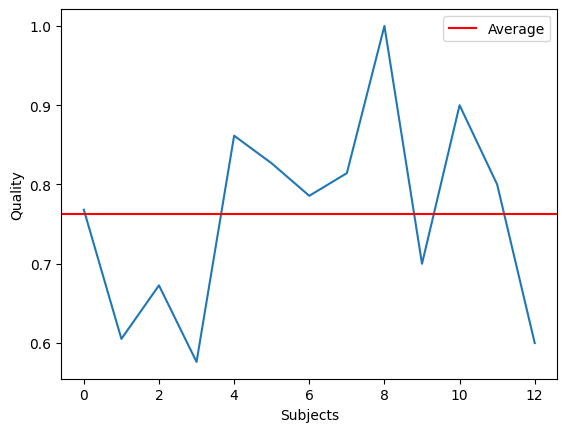

In [19]:
subject = data_sub['Subject'].values
print(subject)
quality_subject = np.zeros(num_subjects)
sub = course_information[:,1]
print(sub)
for i in range(num_courses):
    teacher = D[i].astype(int)
    sub_id = course_information[i,1]
    quality_subject[sub_id] += quality_class[teacher,i] / 10

for i in range(num_subjects):
    print(np.count_nonzero(sub == i))
    quality_subject[i] = quality_subject[i] / np.count_nonzero(sub == i)

average = sum(quality_subject) / num_subjects
plt.plot(np.arange(subject.size), quality_subject)
plt.axhline(y = average, color = 'red',label ='Average')
plt.xlabel('Subjects')
plt.ylabel('Quality')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

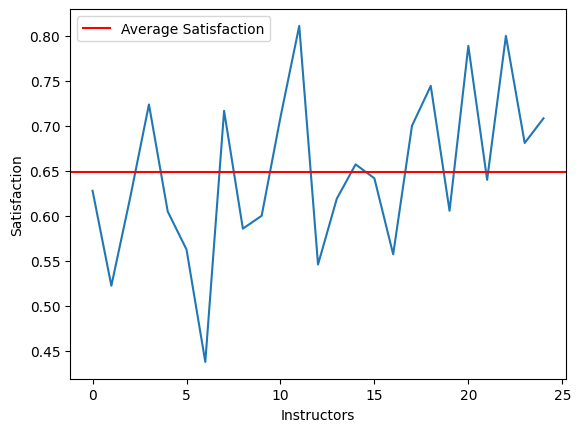

In [20]:
satisfaction_instructor = np.zeros(num_instructors)

for i in range(num_instructors):
    satisfaction_instructor[i] = getScore(i) / np.count_nonzero(D == i)

average_satisfaction = np.sum(satisfaction_instructor) / num_instructors
plt.plot(instructor, satisfaction_instructor)
plt.axhline(y = average_satisfaction, color = 'red',label ='Average Satisfaction')
plt.xlabel('Instructors')
plt.ylabel('Satisfaction')
plt.legend()
plt.show

17374


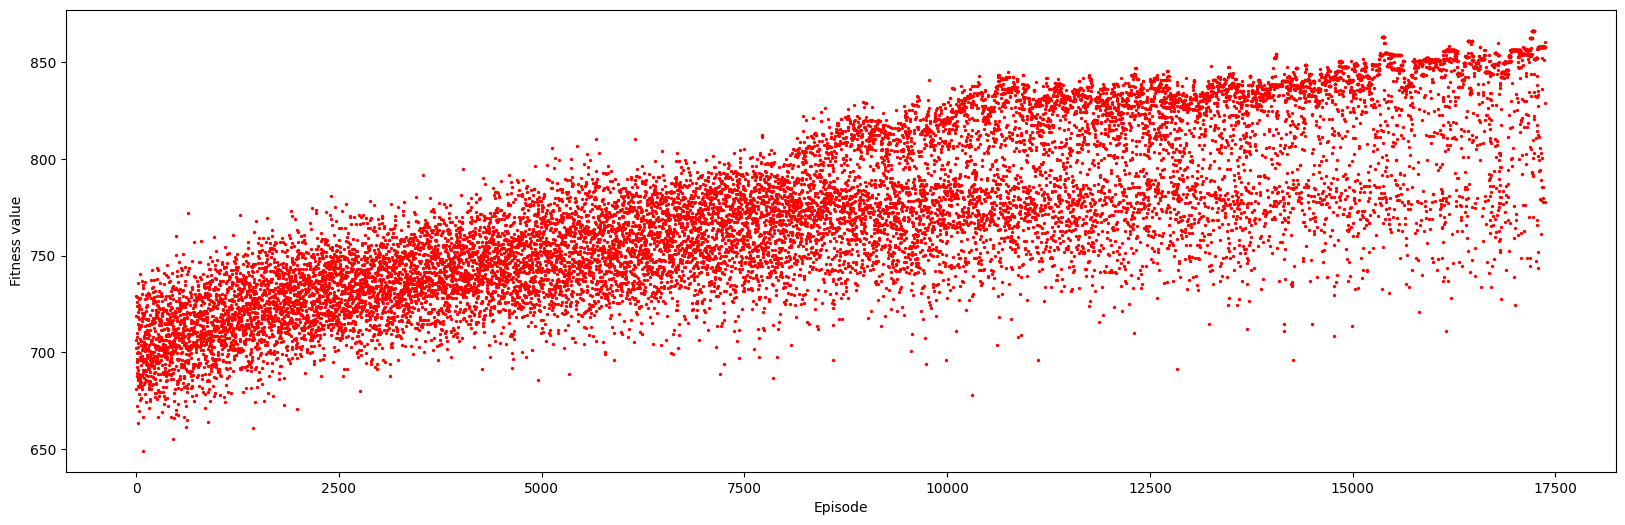

In [21]:
episode_number = np.arange(0 ,fitness_value_id)
print(fitness_value_id)
fitness_value = fitness_value[0:fitness_value_id]
plt.figure(figsize=(20, 6))
plt.scatter(episode_number,fitness_value,color='red', s=2)
plt.xlabel('Episode')
plt.ylabel('Fitness value')
plt.show()